In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

from part_1_utils import readfile, batchGenerator,createMatrices, addCharInfo, padding,EarlyStopper
from keras.utils import plot_model

import gensim.downloader
from seqeval.metrics import f1_score
from seqeval.scheme import IOB1
import tensorflow as tf
from keras.models import Model
from keras.layers import TimeDistributed, Conv1D, Dense, Embedding, Input, Dropout, LSTM, Bidirectional, MaxPooling1D, \
    Flatten, concatenate,Masking
from keras.initializers import RandomUniform
from keras.optimizers import Nadam
import random
import time



2023-11-10 22:23:49.981048: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
google_news_vec = gensim.downloader.load('word2vec-google-news-300')

# Question 1.1

### a)

In [3]:
most_similar_word = google_news_vec.most_similar('student')[0][0]
most_similar_score = google_news_vec.most_similar('student')[0][1]
print(f"The most similar word to the word 'student' is {most_similar_word} and the cosine similarity is {most_similar_score}")

The most similar word to the word 'student' is students and the cosine similarity is 0.7294867038726807


### b)

In [4]:
most_similar_word = google_news_vec.most_similar('Apple')[0][0]
most_similar_score = google_news_vec.most_similar('Apple')[0][1]
print(f"The most similar word to the word 'Apple' is {most_similar_word} and the cosine similarity is {most_similar_score}")

The most similar word to the word 'Apple' is Apple_AAPL and the cosine similarity is 0.7456986308097839


### c)

In [5]:
most_similar_word = google_news_vec.most_similar('apple')[0][0]
most_similar_score = google_news_vec.most_similar('apple')[0][1]
print(f"The most similar word to the word 'apple' is {most_similar_word} and the cosine similarity is {most_similar_score}")

The most similar word to the word 'apple' is apples and the cosine similarity is 0.720359742641449


# Question 1.2

### a) Training File Size: 14041, Development File Size: 3250, Test File Size: 3453

In [6]:
train_lines = open('data/eng.train','r').read().splitlines()
dev_lines = open('data/eng.testa','r').read().splitlines()
test_lines = open('data/eng.testb','r').read().splitlines()


In [7]:
# The original data files have -DOCSTART- lines used to separate documents --> Extra handling required
train_lines

['EU NNP I-NP I-ORG',
 'rejects VBZ I-VP O',
 'German JJ I-NP I-MISC',
 'call NN I-NP O',
 'to TO I-VP O',
 'boycott VB I-VP O',
 'British JJ I-NP I-MISC',
 'lamb NN I-NP O',
 '. . O O',
 '',
 'Peter NNP I-NP I-PER',
 'Blackburn NNP I-NP I-PER',
 '',
 'BRUSSELS NNP I-NP I-LOC',
 '1996-08-22 CD I-NP O',
 '',
 'The DT I-NP O',
 'European NNP I-NP I-ORG',
 'Commission NNP I-NP I-ORG',
 'said VBD I-VP O',
 'on IN I-PP O',
 'Thursday NNP I-NP O',
 'it PRP B-NP O',
 'disagreed VBD I-VP O',
 'with IN I-PP O',
 'German JJ I-NP I-MISC',
 'advice NN I-NP O',
 'to TO I-PP O',
 'consumers NNS I-NP O',
 'to TO I-VP O',
 'shun VB I-VP O',
 'British JJ I-NP I-MISC',
 'lamb NN I-NP O',
 'until IN I-SBAR O',
 'scientists NNS I-NP O',
 'determine VBP I-VP O',
 'whether IN I-SBAR O',
 'mad JJ I-NP O',
 'cow NN I-NP O',
 'disease NN I-NP O',
 'can MD I-VP O',
 'be VB I-VP O',
 'transmitted VBN I-VP O',
 'to TO I-PP O',
 'sheep NN I-NP O',
 '. . O O',
 '',
 'Germany NNP I-NP I-LOC',
 "'s POS B-NP O",
 'rep

In [ ]:
test_lines

['SOCCER NN I-NP O',
 '- : O O',
 'JAPAN NNP I-NP I-LOC',
 'GET VB I-VP O',
 'LUCKY NNP I-NP O',
 'WIN NNP I-NP O',
 ', , O O',
 'CHINA NNP I-NP I-PER',
 'IN IN I-PP O',
 'SURPRISE DT I-NP O',
 'DEFEAT NN I-NP O',
 '. . O O',
 '',
 'Nadim NNP I-NP I-PER',
 'Ladki NNP I-NP I-PER',
 '',
 'AL-AIN NNP I-NP I-LOC',
 ', , O O',
 'United NNP I-NP I-LOC',
 'Arab NNP I-NP I-LOC',
 'Emirates NNPS I-NP I-LOC',
 '1996-12-06 CD I-NP O',
 '',
 'Japan NNP I-NP I-LOC',
 'began VBD I-VP O',
 'the DT I-NP O',
 'defence NN I-NP O',
 'of IN I-PP O',
 'their PRP$ I-NP O',
 'Asian JJ I-NP I-MISC',
 'Cup NNP I-NP I-MISC',
 'title NN I-NP O',
 'with IN I-PP O',
 'a DT I-NP O',
 'lucky JJ I-NP O',
 '2-1 CD I-NP O',
 'win VBP I-VP O',
 'against IN I-PP O',
 'Syria NNP I-NP I-LOC',
 'in IN I-PP O',
 'a DT I-NP O',
 'Group NNP I-NP O',
 'C NNP I-NP O',
 'championship NN I-NP O',
 'match NN I-NP O',
 'on IN I-PP O',
 'Friday NNP I-NP O',
 '. . O O',
 '',
 'But CC O O',
 'China NNP I-NP I-LOC',
 'saw VBD I-VP O',
 

In [ ]:
def count_sentences(lines):
    count=0
    for idx,line in enumerate(lines):
        if line=='':
            count+=1
        # case where line start with -DOCSTART
        elif line.startswith('-DOCSTART'):
            #If reach end of line continue
            if idx+1==len(lines):
                continue
            else:
                # If next line followed by -DOCSTART- -X- O O is a newline minus count by 1
                if lines[idx+1]=='':
                    count-=1
    return count

In [ ]:
train_count = count_sentences(train_lines)
dev_count = count_sentences(dev_lines)
test_count = count_sentences(test_lines)

print(f"Training File Size: {train_count}, Development File Size: {dev_count}, Test File Size: {test_count}." )

Training File Size: 14041, Development File Size: 3250, Test File Size: 3453.


### b)

In [10]:
# Fifth sentence in the training data set has at least two named entities with more than one word

#Extracting the fifth sentence manually
sample_sentence = train_lines[47:78]
sample_sentence

['Germany NNP I-NP I-LOC',
 "'s POS B-NP O",
 'representative NN I-NP O',
 'to TO I-PP O',
 'the DT I-NP O',
 'European NNP I-NP I-ORG',
 'Union NNP I-NP I-ORG',
 "'s POS B-NP O",
 'veterinary JJ I-NP O',
 'committee NN I-NP O',
 'Werner NNP I-NP I-PER',
 'Zwingmann NNP I-NP I-PER',
 'said VBD I-VP O',
 'on IN I-PP O',
 'Wednesday NNP I-NP O',
 'consumers NNS I-NP O',
 'should MD I-VP O',
 'buy VB I-VP O',
 'sheepmeat NN I-NP O',
 'from IN I-PP O',
 'countries NNS I-NP O',
 'other JJ I-ADJP O',
 'than IN I-PP O',
 'Britain NNP I-NP I-LOC',
 'until IN I-SBAR O',
 'the DT I-NP O',
 'scientific JJ I-NP O',
 'advice NN I-NP O',
 'was VBD I-VP O',
 'clearer JJR I-ADJP O',
 '. . O O']

In [11]:
# Function to form complete named entities from the label for each words and all the named entities in this sentence
def form_named_entities(sentence):
    words = []
    labels = []
    for line in sentence:
        words.append(line.split()[0])
        labels.append(line.split()[-1])
    named_entities = []
    is_prev_added = False
    temp_word=None
    for i in range(1, len(labels)):
        if (labels[i] == labels[i-1]) and (labels[i-1] != 'O' and labels[i]!= 'O'):
            # If nothing was added to named_entities in the previous loop --> Add current word and the word before
            if not is_prev_added:
                temp_word = ' '.join(words[i-1:i+1])
                is_prev_added=True
            else:
                temp_word = ' '.join([temp_word,words[i]])
        else:
            if is_prev_added:
                named_entities.append(temp_word)
            is_prev_added=False
    
    # Handle edge case where the last few words are named entities
    if is_prev_added:
        named_entities.append(temp_word)
            
    return named_entities

In [12]:
named_entities = form_named_entities(sample_sentence)

In [13]:
named_entities

['European Union', 'Werner Zwingmann']

# Qns 1.3

### Data Preprocessing

In [3]:
# read train,val,test file
trainSentences = readfile("data/eng.train")
devSentences = readfile("data/eng.testa")
testSentences = readfile("data/eng.testb")

# add character info for each word
# e.g --> [['EU', ['E', 'U'], 'B-ORG'], ...]
trainSentences = addCharInfo(trainSentences)
devSentences = addCharInfo(devSentences)
testSentences = addCharInfo(testSentences)



labelSet = set()
wordSet = set()

# unique words and labels in data  
for dataset in [trainSentences, devSentences, testSentences]:
    for sentence in dataset:
        for word, char, label in sentence:
            labelSet.add(label)
            wordSet.add(word.lower())

# mapping for labels
label2Idx = {}
label2Idx['PADDING_TOKEN'] = 0
for label in labelSet:
    label2Idx[label] = len(label2Idx)

idx2Label = {v: k for k, v in label2Idx.items()}

# mapping for cases
case2Idx = {'PADDING_TOKEN':0, 'numeric': 1, 'allLower': 2, 'allUpper': 3, 'initialUpper': 4, 'mainly_numeric': 5,
            'contains_digit': 6, 'hyphen': 7, 'other': 8}
caseEmbeddings = np.identity(len(case2Idx), dtype='float32')  # identity matrix used 

word2Idx = {}

embed_size = len(google_news_vec.vectors[0])

# Get all words in the word2vec model
w2v_dictionary = list(google_news_vec.key_to_index.keys())

wordEmbeddings = []
# adding vector for padding token
wordEmbeddings.append(np.zeros(embed_size))
# adding vector for unknown vector intialised with uniform distribution
wordEmbeddings.append(np.random.uniform(-0.25, 0.25, embed_size))

word2Idx = {}
# add padding+unknown
word2Idx["PADDING_TOKEN"] = len(word2Idx)
word2Idx["UNKNOWN_TOKEN"] = len(word2Idx)

# adding vector for words present in the CoNLL2003 dataset
for word in w2v_dictionary:
    try:
        if word.lower() in wordSet:
            embedding_vector = google_news_vec.get_vector(word)
            if embedding_vector is not None:
                wordEmbeddings.append(embedding_vector)
                word2Idx[word] = len(word2Idx)
    except Exception as e:
        pass

wordEmbeddings = np.array(wordEmbeddings)

# dictionary of all possible characters
char2Idx = {"PADDING_TOKEN": 0, "UNKNOWN_TOKEN": 1}
for c in " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|<>":
    char2Idx[c] = len(char2Idx)

# format: [[padded wordindices], [caseindices], [padded char indices], [label indices]]
train_set = padding(createMatrices(trainSentences, word2Idx, label2Idx, case2Idx, char2Idx))
dev_set = padding(createMatrices(devSentences, word2Idx, label2Idx, case2Idx, char2Idx))
test_set = padding(createMatrices(testSentences, word2Idx, label2Idx, case2Idx, char2Idx))


### Model Architecture

Architecture --> CNN + Bi-LSTM
hyperparams to tune --> dropout, dropout_rnn,lstm_hidden_neurons,conv_size,lr

    - Custom Masking layer for padded tokens in the CNN Layers --> Conv1D, MaxPooling1D and Flatten Layer 
        - BY default does not support masking

In [4]:
# Custom masking layer has to be created to mask padded tokens as normal conv1d,MaxPooling1D and Flatten layer dont support masking
class MaskingConv1D(Conv1D):
    def __init__(self, **kwargs):
        super(MaskingConv1D, self).__init__(**kwargs)
        self.supports_masking = True


class MaskingMaxPooling1D(MaxPooling1D):
    def __init__(self, pool_size, **kwargs):
        super(MaskingMaxPooling1D, self).__init__(pool_size, **kwargs)
        self.supports_masking = True


class MaskingFlatten(Flatten):
    def __init__(self, **kwargs):
        super(MaskingFlatten, self).__init__(**kwargs)
        self.supports_masking = True

In [5]:
"""Initialise class"""

class CNN_BLSTM(object):
    
    def __init__(self,epochs, dropout, dropout_rnn, lstm_hidden_neurons, conv_size, lr, optimizer,batch_size):
        
        self.epochs = epochs
        self.dropout = dropout
        self.dropout_rnn = dropout_rnn
        self.lstm_hidden_neurons = lstm_hidden_neurons
        self.conv_size = conv_size
        self.lr = lr
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.run_time = 0
        
    
    def buildModel(self,wordEmbeddings,caseEmbeddings,char2Idx,label2Idx):
        """Model layers"""

        # character input,embedding
        character_input = Input(shape=(None, 52,), name="Character_input")
        character_input = Masking(mask_value=0)(character_input)
        embed_char_out = TimeDistributed(
            Embedding(len(char2Idx), 30, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)),name="Character_embedding")(
            character_input)
        
        dropout = Dropout(self.dropout)(embed_char_out)

        # CNN
        conv1d_out = TimeDistributed(MaskingConv1D(kernel_size=self.conv_size, filters=30, padding='same', activation='relu', strides=1), name="Convolution")(dropout)
        maxpool_out = TimeDistributed(MaskingMaxPooling1D(pool_size=52), name="Maxpool")(conv1d_out)
        char = TimeDistributed(MaskingFlatten(), name="Flatten")(maxpool_out)
        char = Dropout(self.dropout)(char)

        # word-level input, embedding
        words_input = Input(shape=(124,), dtype='int32', name='words_input')
        words_input = Masking(mask_value=0)(words_input)

        words = Embedding(input_dim=wordEmbeddings.shape[0], output_dim=wordEmbeddings.shape[1], weights=[wordEmbeddings],
                          trainable=False)(words_input)

        # case-level input,embedding
        casing_input = Input(shape=(124,), dtype='int32', name='casing_input')
        casing_input = Masking(mask_value=0)(casing_input)
        casing = Embedding(input_dim=caseEmbeddings.shape[0],output_dim=caseEmbeddings.shape[1], weights=[caseEmbeddings],
                           trainable=False)(casing_input)

        # concat &  pass to BLSTM
        output = concatenate([words, casing, char])
        output = Bidirectional(LSTM(self.lstm_hidden_neurons, 
                                    return_sequences=True, 
                                    dropout=self.dropout,                        # on input to each LSTM block
                                    recurrent_dropout=self.dropout_rnn     # on recurrent input signal
                                   ), name="BLSTM")(output)
        
        # Fully connected layer with softmax activation
        output = TimeDistributed(Dense(len(label2Idx), activation='softmax'),name="Softmax_layer")(output)

        self.model = Model(inputs=[words_input, casing_input, character_input], outputs=[output])
        
        # compile model
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=self.optimizer)
        
        self.init_weights = self.model.get_weights()
        
        plot_model(self.model, to_file='model.png')
        
        print("Model built. Saved model.png\n")


        
    def train(self,train_set,dev_set,early_stopper):

        def index_to_tag(index):
            return idx2Label[index]
        
        self.f1_devs = []
        self.f1_train = []
        max_f1 = -1
        for epoch in range(self.epochs):    
            print("Epoch {}/{}".format(epoch, self.epochs))
            epoch_start = time.time()
            random.shuffle(train_set)

            for batch_gen in batchGenerator(train_set,batch_size=self.batch_size):
                words,cases,chars,labels = batch_gen
                self.model.train_on_batch([words,cases,chars],labels)
            
            batch_f1_devs = []
            for batch_gen in batchGenerator(dev_set,batch_size=self.batch_size):
                words,cases,chars,labels = batch_gen
                preds = self.model.predict_on_batch([words,cases,chars])
                preds = preds.argmax(axis=-1)

                # Convert class labels back to tag label to use seqeval f1_score
                idx2label_vec = np.vectorize(index_to_tag)
                preds = idx2label_vec(preds).tolist()
                labels = idx2label_vec(labels).tolist()

                # Ignore padded_tokens during evaluation of f1_score
                non_padded_preds = []
                non_padded_labels = []
                for idx_1,sentence in enumerate(labels):
                    # padding token corresponds to class 0
                    non_padded_pred = []
                    non_padded_label = []
                    for idx_2,token in  enumerate(sentence):
                        if token!="PADDING_TOKEN" and preds[idx_1][idx_2]!='PADDING_TOKEN':
                            non_padded_pred.append(preds[idx_1][idx_2])
                            non_padded_label.append(labels[idx_1][idx_2])
                    non_padded_preds.append(non_padded_pred)
                    non_padded_labels.append(non_padded_label)

                # Calculate using seqeval f1_score
                batch_f1_devs.append(f1_score(non_padded_labels,non_padded_preds,scheme=IOB1))

            f1_dev = np.average(batch_f1_devs)

            # Add time taken for each epoch
            self.run_time+=(time.time()-epoch_start)

            # Save the best model weight
            if f1_dev>max_f1:
                max_f1 =f1_dev
                # save model
                self.modelName = "{}_{}_{}_{}_{}_{}_{}_{}".format(self.epochs, 
                                                                self.dropout, 
                                                                self.dropout_rnn, 
                                                                self.lstm_hidden_neurons,
                                                                self.conv_size,
                                                                self.lr,
                                                                self.batch_size,
                                                                self.optimizer.__class__.__name__
                                                            )
                
                modelName = self.modelName + ".h5"
                self.model.save(f"./model_weights/{modelName}")
                print("Model weights saved.")

            self.f1_devs.append(f1_dev)
            print("f1 dev ", round(f1_dev, 4), "\n")
            
            if early_stopper.early_stop(f1_dev):
                print('Early Stopping!')
                break

        print("Training finished.")

### Tuning with Optuna

- Use optuna to guide tuning of parameters
    - Which parameter is most important to tune?
    - Which direction to tune?

In [9]:
import optuna

/opt/anaconda3/envs/CZ4045/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
# model creation
def create_model(trial):

    # Hyperparameters to tune
    dropout = trial.suggest_float("dropout",0.2,0.7,step=0.1)
    conv_size = trial.suggest_int("conv_size",1,9,step=2)
    lstm_hidden_neurons = trial.suggest_int('lstm_hidden_neurons',128,256,step=16)

# character input,embedding
    character_input = Input(shape=(None, 52,), name="Character_input")
    character_input = Masking(mask_value=0)(character_input)
    embed_char_out = TimeDistributed(
        Embedding(len(char2Idx), 30, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)),name="Character_embedding")(
        character_input)
    embed_output = Dropout(dropout)(embed_char_out)

    # CNN
    conv1d_out = TimeDistributed(MaskingConv1D(kernel_size=conv_size, filters=30, padding='same', activation='relu', strides=1), name="Convolution")(embed_output)
    maxpool_out = TimeDistributed(MaskingMaxPooling1D(52), name="Maxpool")(conv1d_out)
    char = TimeDistributed(MaskingFlatten(), name="Flatten")(maxpool_out)
    char = Dropout(dropout)(char)

    # word-level input, embedding
    words_input = Input(shape=(124,), dtype='int32', name='words_input')
    words_input = Masking(mask_value=0)(words_input)
    words = Embedding(input_dim=wordEmbeddings.shape[0], output_dim=wordEmbeddings.shape[1], weights=[wordEmbeddings],
                        trainable=False)(words_input)

    # case-level input,embedding
    casing_input = Input(shape=(124,), dtype='int32', name='casing_input')
    casing_input = Masking(mask_value=0)(casing_input)
    casing = Embedding(input_dim=caseEmbeddings.shape[0],output_dim=caseEmbeddings.shape[1], weights=[caseEmbeddings],
                        trainable=False)(casing_input)

    # concat &  pass to BLSTM
    output = concatenate([words, casing, char])
    dropout_rnn = trial.suggest_float('dropout_rnn',0.1,0.6,step=0.1)
    output = Bidirectional(LSTM(lstm_hidden_neurons, 
                                return_sequences=True, 
                                dropout=dropout,                        # on input to each LSTM block
                                recurrent_dropout=dropout_rnn     # on recurrent input signal
                                ), name="BLSTM")(output)
    
    # Fully connected layer with softmax activation
    output = TimeDistributed(Dense(len(label2Idx), activation='softmax'),name="Softmax_layer")(output)

    model = Model(inputs=[words_input, casing_input, character_input], outputs=[output])    
    
    return model

In [41]:
def create_optimizer(trial):
    kwargs = {}
    optimizer_selected = "Nadam"
    kwargs["learning_rate"] = trial.suggest_float("Nadam_learning_rate", 1e-3, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer    

In [44]:
def objective(trial):
    epochs = 50
    # Generate our trial model.
    model = create_model(trial)
    # Generate the trial optimizer
    optimizer = create_optimizer(trial)
    
    # compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)
    early_stopper = EarlyStopper(patience=5)

    def index_to_tag(index):
        return idx2Label[index]
    
    max_f1 = -1
    for epoch in range(epochs):    
        random.shuffle(train_set)
        # train_batches = split_batch(train_set,batch_size=128)
        # for batch in train_batches:
        for batch_gen in batchGenerator(train_set,batch_size=128):
            words,cases,chars,labels = batch_gen
            model.train_on_batch([words,cases,chars],labels)
        
        batch_f1_devs = []
        # dev_batches = split_batch(dev_set,batch_size=128)
        # for batch in dev_batches:
        for batch_gen in batchGenerator(dev_set,batch_size=128):
            words,cases,chars,labels = batch_gen
            preds = model.predict_on_batch([words,cases,chars])
            preds = preds.argmax(axis=-1)

            # Convert class labels back to tag label to use seqeval f1_score
            idx2label_vec = np.vectorize(index_to_tag)
            preds = idx2label_vec(preds).tolist()
            labels = idx2label_vec(labels).tolist()

            # Ignore padded_tokens during evaluation of f1_score
            non_padded_preds = []
            non_padded_labels = []
            for idx_1,sentence in enumerate(labels):
                # padding token corresponds to class 0
                non_padded_pred = []
                non_padded_label = []
                for idx_2,token in  enumerate(sentence):
                    if token!="PADDING_TOKEN" and preds[idx_1][idx_2]!='PADDING_TOKEN':
                        non_padded_pred.append(preds[idx_1][idx_2])
                        non_padded_label.append(labels[idx_1][idx_2])
                non_padded_preds.append(non_padded_pred)
                non_padded_labels.append(non_padded_label)

            # Calculate using seqeval f1_score
            batch_f1_devs.append(f1_score(non_padded_labels,non_padded_preds,scheme=IOB1))

        f1_dev = np.average(batch_f1_devs)
        if f1_dev>max_f1:
            max_f1=f1_dev

        if early_stopper.early_stop(f1_dev):
            break
            
    # Evaluate the model accuracy on the validation set.
    return max_f1

In [11]:
from sqlalchemy import create_engine
# create sqlite db to store optuna results 
engine = create_engine('sqlite:///cnn_blstm.db')

storage_url = 'sqlite:///cnn_blstm.db'
study_name = 'cnn_blstm'

In [46]:
study = optuna.create_study(study_name=study_name,storage=storage_url,direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=50)

print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-02 20:32:48,672] A new study created in RDB with name: cnn_blstm
[I 2023-11-02 23:00:48,634] Trial 0 finished with value: 0.9182110813007468 and parameters: {'dropout': 0.6000000000000001, 'conv_size': 1, 'lstm_hidden_neurons': 128, 'dropout_rnn': 0.30000000000000004, 'Nadam_learning_rate': 0.001945698397030893}. Best is trial 0 with value: 0.9182110813007468.
[I 2023-11-03 00:26:23,094] Trial 1 finished with value: 0.9159688030825571 and parameters: {'dropout': 0.6000000000000001, 'conv_size': 9, 'lstm_hidden_neurons': 160, 'dropout_rnn': 0.2, 'Nadam_learning_rate': 0.008654157022684437}. Best is trial 0 with value: 0.9182110813007468.
/opt/anaconda3/envs/CZ4045/lib/python3.10/site-packages/seqeval/metrics/v1.py:159: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
[I 2023-11-03 04:13:38,088] Trial 2 finished with value: 0.0 and parameters: {'dropout

Number of finished trials:  50
Best trial:
  Value:  0.9256837858891689
  Params: 
    dropout: 0.30000000000000004
    conv_size: 5
    lstm_hidden_neurons: 144
    dropout_rnn: 0.5
    Nadam_learning_rate: 0.006489975373979341


In [14]:
loaded_study = optuna.load_study(storage=storage_url,study_name=study_name)

### Hyper-Parameter Importances

- Learning Rate seems to have the largest impact

In [15]:
fig = optuna.visualization.plot_param_importances(loaded_study)
fig.show()

- Learning Rate between 0.001 and 0.01 seems to be optimal , any values larger or smaller than that results in worse accuracy


In [18]:
fig = optuna.visualization.plot_slice(loaded_study,params=['Nadam_learning_rate','dropout','dropout_rnn','lstm_hidden_neurons'])
fig.show()

### Conv Size against Dropout
    -High Convolution Size and mid-range dropout doesnt seem ideal


In [49]:
fig = optuna.visualization.plot_contour(study=loaded_study,params=['conv_size','dropout'])
fig.show()

### lstm_hidden_neuron vs dropout_rnn
    - Avoid setting 0.4-0.6 dropout rnn with High LSTM state size

In [50]:
fig = optuna.visualization.plot_contour(study=loaded_study,params=['lstm_hidden_neurons','dropout_rnn'])
fig.show()

### Training Best Model

- Further fine tune based on findings from tuning process
    - Experimented with lower batch sizes and lower learning rate
    - Tried lowering dropout more

In [7]:
"""Set parameters based on tuning results above"""

EPOCHS = 125               
DROPOUT = 0.3            
DROPOUT_RECURRENT = 0.5  
LSTM_STATE_SIZE = 176     
CONV_SIZE = 3             
LEARNING_RATE = 0.002    
OPTIMIZER = Nadam(learning_rate=LEARNING_RATE)
BATCH_SIZE = 64
early_stopper = EarlyStopper(patience=10,min_delta=0.003)

In [76]:
"""Construct and run model"""
cnn_blstm = CNN_BLSTM(EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER,BATCH_SIZE)
cnn_blstm.buildModel(wordEmbeddings,caseEmbeddings,char2Idx,label2Idx)
cnn_blstm.train(train_set,dev_set,early_stopper)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model built. Saved model.png

Epoch 0/125


/opt/anaconda3/envs/CZ4045/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model weights saved.
f1 dev  0.8 

Epoch 1/125
Model weights saved.
f1 dev  0.8462 

Epoch 2/125
Model weights saved.
f1 dev  0.8615 

Epoch 3/125
Model weights saved.
f1 dev  0.8776 

Epoch 4/125
f1 dev  0.8741 

Epoch 5/125
Model weights saved.
f1 dev  0.8916 

Epoch 6/125
Model weights saved.
f1 dev  0.8968 

Epoch 7/125
Model weights saved.
f1 dev  0.9028 

Epoch 8/125
Model weights saved.
f1 dev  0.9041 

Epoch 9/125
Model weights saved.
f1 dev  0.9103 

Epoch 10/125
Model weights saved.
f1 dev  0.9133 

Epoch 11/125
f1 dev  0.9114 

Epoch 12/125
Model weights saved.
f1 dev  0.9195 

Epoch 13/125
f1 dev  0.9177 

Epoch 14/125
f1 dev  0.9189 

Epoch 15/125
f1 dev  0.9169 

Epoch 16/125
f1 dev  0.9184 

Epoch 17/125
f1 dev  0.919 

Epoch 18/125
f1 dev  0.917 

Epoch 19/125
Model weights saved.
f1 dev  0.9219 

Epoch 20/125
f1 dev  0.9189 

Epoch 21/125
f1 dev  0.9213 

Epoch 22/125
Model weights saved.
f1 dev  0.923 

Epoch 23/125
Model weights saved.
f1 dev  0.9235 

Epoch 24/125
f

# Results

### Predict on Test set

In [78]:
def index_to_tag(index):
    return idx2Label[index]

# predict on entire test set which has size 3453
for batch_gen in batchGenerator(test_set,batch_size=3453):
    words,cases,chars,labels = batch_gen
    preds = cnn_blstm.model.predict_on_batch([words,cases,chars])
    preds = preds.argmax(axis=-1)

    # Convert class labels back to tag label to use seqeval f1_score
    idx2label_vec = np.vectorize(index_to_tag)
    preds = idx2label_vec(preds).tolist()
    labels = idx2label_vec(labels).tolist()

    # Ignore padded_tokens during evaluation of f1_score
    non_padded_preds = []
    non_padded_labels = []
    for idx_1,sentence in enumerate(labels):
        # padding token corresponds to class 0
        non_padded_pred = []
        non_padded_label = []
        for idx_2,token in  enumerate(sentence):
            if token!="PADDING_TOKEN" and preds[idx_1][idx_2]!='PADDING_TOKEN':
                non_padded_pred.append(preds[idx_1][idx_2])
                non_padded_label.append(labels[idx_1][idx_2])
        non_padded_preds.append(non_padded_pred)
        non_padded_labels.append(non_padded_label)

In [79]:
print(f"Test F1 Score: {f1_score(non_padded_labels,non_padded_preds,scheme=IOB1)}")

Test F1 Score: 0.8802369131608745


### Total Training Time

In [80]:
print(f"Total Run Time is {cnn_blstm.run_time}")

Total Run Time is 34455.767475128174


### Plot F1 Dev Against Epoch

- Early Stopping at epoch

In [81]:
import matplotlib.pyplot as plt

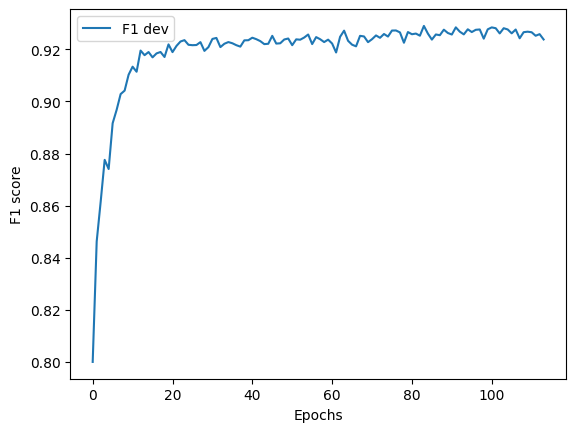

In [82]:
plt.plot(cnn_blstm.f1_devs, label = "F1 dev")
plt.xlabel("Epochs")
plt.ylabel("F1 score")
plt.legend()
plt.show()